# Proyecto Final Karina Cardozo
# p5_Modelo

# 1) Cargamos los datos 📕

In [1]:
import pandas as pd
from funpymodeling.exploratory import status, freq_tbl

In [2]:
# Para visualizar todas las columnas
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv("data/ohe_customer_dataset.csv", sep=',') 

In [4]:
import mlflow.sklearn

mlflow.set_experiment(experiment_name="proyecto_final_kcardozo")

<Experiment: artifact_location='file:///c:/Users/karina/bcamp/Data%20Science/12_Trabajo%20Final/Parte_A/mlruns/691501955265869603', creation_time=1686792598666, experiment_id='691501955265869603', last_update_time=1686792598666, lifecycle_stage='active', name='proyecto_final_kcardozo', tags={}>

In [5]:
#!mlflow ui

In [6]:
data.head(5)

,transactionFailed,fraudulent,"orderAmount_(9.999, 18.4]","orderAmount_(18.4, 30.0]","orderAmount_(30.0, 39.0]","orderAmount_(39.0, 47.0]","orderAmount_(47.0, 353.0]",orderAmount_desconocido,orderState_failed,orderState_fulfilled,orderState_pending,paymentMethodRegistrationFailure_False,paymentMethodRegistrationFailure_True,paymentMethodType_apple pay,paymentMethodType_bitcoin,paymentMethodType_card,paymentMethodType_paypal,paymentMethodProvider_American Express,paymentMethodProvider_Diners Club / Carte Blanche,paymentMethodProvider_Discover,paymentMethodProvider_JCB 15 digit,paymentMethodProvider_JCB 16 digit,paymentMethodProvider_Maestro,paymentMethodProvider_Mastercard,paymentMethodProvider_VISA 13 digit,paymentMethodProvider_VISA 16 digit,paymentMethodProvider_Voyager,paymentMethodIssuer_Bastion Banks,paymentMethodIssuer_Bulwark Trust Corp.,paymentMethodIssuer_Citizens First Banks,paymentMethodIssuer_Fountain Financial Inc.,paymentMethodIssuer_Grand Credit Corporation,paymentMethodIssuer_Her Majesty Trust,paymentMethodIssuer_His Majesty Bank Corp.,paymentMethodIssuer_Rose Bancshares,paymentMethodIssuer_Solace Banks,paymentMethodIssuer_Vertex Bancorp,paymentMethodIssuer_weird,"transactionAmount_(9.999, 21.0]","transactionAmount_(21.0, 34.0]","transactionAmount_(34.0, 45.0]","transactionAmount_(45.0, 353.0]",emailDomain_biz,emailDomain_com,emailDomain_info,emailDomain_net,emailDomain_org,emailDomain_weird,emailProvider_gmail,emailProvider_hotmail,emailProvider_other,emailProvider_weird,emailProvider_yahoo,customerIPAddressSimplified_digits_and_letters,customerIPAddressSimplified_only_letters,sameCity_no,sameCity_unknown,sameCity_yes
0,False,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1
1,False,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0
2,False,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
3,False,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
4,True,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0


# 3) Clasificación 🎯

## 3.1) Separación de X de Y, y luego TR de TS (rutina):

In [7]:
data_x = data.drop('fraudulent', axis=1)
data_y = data['fraudulent']

In [8]:
#Nos quedamos solo con los valores del dataframe
data_x = data_x.values
data_y = data_y.values

In [9]:
# Porcentaje del dataset para el test
TEST_SIZE = 0.3

In [10]:
mlflow.log_param("Porcentaje de test", TEST_SIZE)

0.3

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=TEST_SIZE)

## 3.2) Creación del modelo predictivo

In [12]:
# Creamos 100 decision trees
NUM_ESTIMATORS = 500
RANDOM_STATE = 99

In [13]:
from sklearn.ensemble import RandomForestClassifier 

# Creamos 500 decision trees
rf = RandomForestClassifier(n_estimators = NUM_ESTIMATORS, random_state = RANDOM_STATE )

In [14]:
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=99)

In [15]:
mlflow.log_param("Número de estimadores", NUM_ESTIMATORS)
mlflow.log_param("Valor semilla", RANDOM_STATE)

99

## 3.3) Predicción de la clase y score

In [16]:
# En training
pred_tr=rf.predict(x_train)

# En testing
pred_ts=rf.predict(x_test)

In [17]:
pred_probs=rf.predict_proba(x_train)

In [18]:
y_prob_tr=pred_probs[:,1]

## 3.4) Matriz de confusión

### a) Valores absolutos:

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

In [20]:
import seaborn as sns

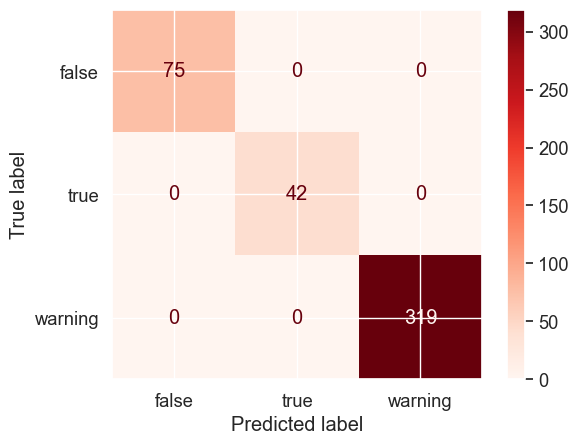

In [21]:
sns.set(font_scale=1.2) #  Ajuste tamaño de letra (var global)

ConfusionMatrixDisplay.from_estimator(
    rf, x_train, y_train,
    display_labels=['false','true','warning'],
    cmap='Reds',
    )

## 4.1 Validamos Training

In [22]:
#Generamos un dataframe con la realidad vrs. lo predicho

df_val_tr=pd.DataFrame({'y_train':y_train, 'pred_tr':pred_tr})

# ¿cuántos aciertos?
sum(df_val_tr.y_train==df_val_tr.pred_tr)/len(df_val_tr)

1.0

In [23]:
from sklearn.metrics import accuracy_score

In [24]:
accuracy_train = accuracy_score(df_val_tr.y_train, df_val_tr.pred_tr, normalize=True)
print(accuracy_train)

1.0


In [25]:
mlflow.log_metric("Accuracy en Train", accuracy_train)

## 4.2 Validamos Testing

In [26]:
#Generamos un dataframe con la realidad vrs. lo predicho

df_val_ts=pd.DataFrame({'y_test':y_test, 'pred_ts':pred_ts})

In [27]:
# ¿cuántos aciertos?
accuracy_test = accuracy_score(df_val_ts.y_test, df_val_ts.pred_ts, normalize=True)
print(accuracy_test)

0.893048128342246


In [28]:
mlflow.log_metric("Accuracy en Test", accuracy_test)

# 5) Guardar un modelo

In [29]:
import pickle

In [30]:
# Guardar en el disco
filename = 'modelo_proyecto_final.pkl'
pickle.dump(rf, open(filename, 'wb')) # rf = nuestro modelo

In [31]:
#Guardar el modelo con mlflow

mlflow.sklearn.log_model(rf, "modelo_proyecto_final")

In [32]:
# Lo cargamos para usarlo en otro momento. 
rf_loaded = pickle.load(open(filename, 'rb'))

In [33]:
!mlflow ui

^C
